In [17]:
import jax
import jax.numpy as jnp
from flax import nnx
import optax

from sklearn.metrics import precision_recall_fscore_support as prf, accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from model import DAGMM
from dataloader import load_kddcup99
from utils import calc_mixture_stats, calc_sample_energies
from train import train

In [8]:
key = jax.random.PRNGKey(42)
batch_size = 1024
key, dataloader_key = jax.random.split(key, 2)

model = DAGMM(n_features=122, rngs=nnx.Rngs(key))
dataloader_train, dataloader_test = load_kddcup99(dataloader_key, batch_size=batch_size)


learning_rate = 0.0001
optimizer = nnx.Optimizer(model, optax.adam(learning_rate))
metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss')
)

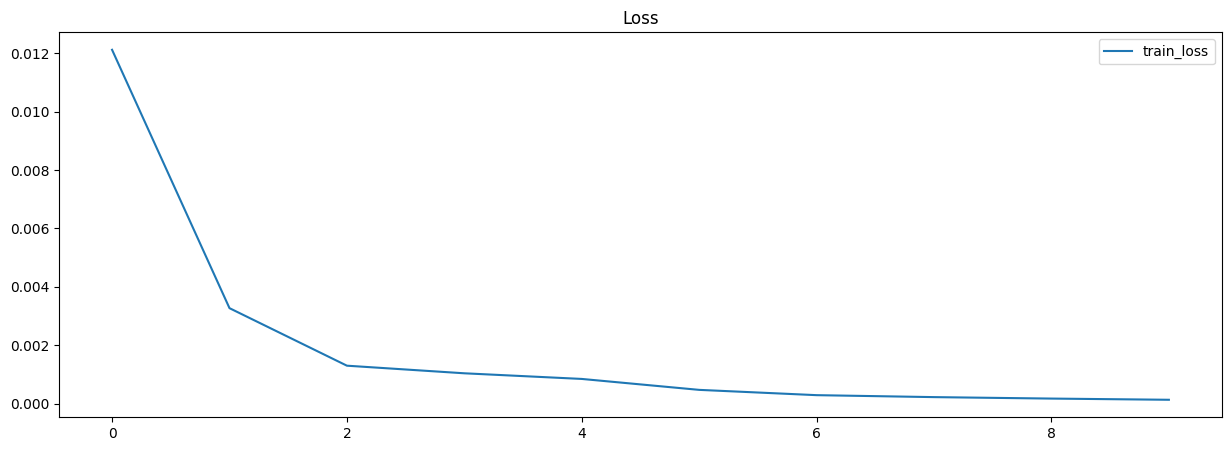

Model saved.


In [9]:
train(model, optimizer, metrics, dataloader_train, epochs=10, save_model=True)


In [10]:
@nnx.jit
def eval_step(model: DAGMM, inputs: jnp.ndarray):
    """Evaluate for a single step."""
    gamma, _, z = model(inputs)
    phi, mu, covariances = calc_mixture_stats(inputs, gamma, z)
    energies = calc_sample_energies(model.k, z, phi, mu, covariances)
    return z, energies

In [ ]:
model.eval()

combined_z = []
combined_energy = []
combined_labels = []

# for step, (inputs, labels) in enumerate(dataloader_train):
#     inputs = jax.tree.map(lambda x: jnp.array(x), inputs)
#     z, energies = eval_step(model, inputs)
    
#     combined_z.append(z)
#     combined_energy.append(energies)
#     combined_labels.append(jnp.array(labels))

with tqdm(total=len(dataloader_test)) as pbar:
    pbar.set_description("Evaluating")
    pbar.update(0)
    for step, (inputs, labels) in tqdm(enumerate(dataloader_test)):
        inputs = jax.tree.map(lambda x: jnp.array(x), inputs)
        z, energies = eval_step(model, inputs)
        
        combined_z.append(z)
        combined_energy.append(energies)
        combined_labels.append(jnp.array(labels))
        pbar.update(1)

combined_z = jnp.concatenate(combined_z, axis=0)
combined_energy = jnp.concatenate(combined_energy, axis=0)
combined_labels = jnp.concatenate(combined_labels, axis=0)

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
threshold = jnp.percentile(combined_energy, 100 - 20)
print(f'Threshold: {threshold}')
y_hat = (combined_energy > threshold).astype(jnp.int32)
y_true = combined_labels.astype(jnp.int32)
print(f'Accuracy: {accuracy_score(y_true, y_hat)}')
precision, recall, f1, _ = prf(y_true, y_hat, average='binary')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(combined_z[: ,1],combined_z[: ,0], combined_z[: ,2], c=combined_labels, cmap='viridis', s=1)
ax.set_xlabel('Encoded')
ax.set_ylabel('Euclidean')
ax.set_zlabel('Cosine')
plt.show()